In [1]:
import numpy as np
import foscat.scat_cov as sc
import matplotlib.pyplot as plt
import sys
import healpy as hp
import foscat.Synthesis as synthe
import xarray as xr
sys.path.append('/home/jmdeloui/healpix-convolution')

In [2]:
dtotal=xr.open_zarr('/home/jmdeloui/DATA/test.zarr')
#dtotal=xr.open_zarr("https://data-fair2adapt.ifremer.fr/odysea/odysea.zarr").pipe(xdggs.decode)
dtotal

<xarray.Dataset> Size: 90MB
Dimensions:    (depth: 8, latitude: 180, longitude: 324, time: 24)
Coordinates:
  * depth      (depth) float32 32B 0.494 1.541 2.646 3.819 ... 6.441 7.93 9.573
  * latitude   (latitude) float32 720B 46.03 46.05 46.08 ... 50.94 50.97 51.0
  * longitude  (longitude) float32 1kB -7.999 -7.971 -7.944 ... 0.9456 0.9733
  * time       (time) datetime64[ns] 192B 2025-03-20 ... 2025-03-20T23:00:00
Data variables:
    thetao     (time, depth, latitude, longitude) float64 90MB dask.array<chunksize=(1, 1, 180, 324), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.8
    comment:      
    contact:      https://marine.copernicus.eu/contact
    institution:  NOW Systems (Spain)
    references:   http://marine.copernicus.eu/
    source:       NEMO3.6
    title:        Ocean 3D hourly mean fields for the Iberia-Biscay-Ireland (...

In [19]:
nside=1024
data = dtotal.thetao.compute().values[12,0,:,:]
longitude=np.tile(dtotal.longitude.compute().values,data.shape[0])
latitude=np.repeat(dtotal.latitude.compute().values,data.shape[1])
input_cell_ids = hp.ang2pix(nside,-longitude,latitude,lonlat=True,nest=True)
data=data.flatten()
input_cell_ids=input_cell_ids[~np.isnan(data)]
data=data[~np.isnan(data)]

cell_ids,inv  = np.unique(input_cell_ids, return_inverse=True)
data=np.bincount(inv,weights=data)
counts=np.bincount(inv)
data=data/counts

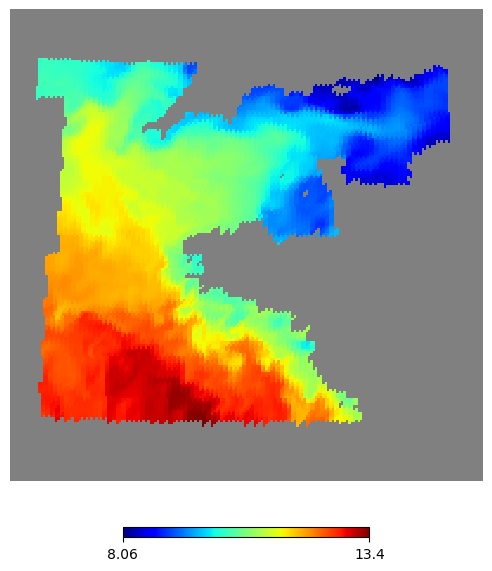

In [24]:
def plot_result(data,cell_ids,nside,hold=None,sub=None,title=None,unit=None,vmin=None,vmax=None):
    im=np.ones([12*nside**2])*hp.UNSEEN
    im[cell_ids]=data
    if vmin is None:
        vmin=data.min()
    if vmax is None:
        vmax=data.max()
    hp.gnomview(im,cmap='jet',nest=True,rot=[3.4,48.5],reso=2,hold=hold,sub=sub,notext=True,title=title,unit=unit,min=vmin,max=vmax)

plot_result(data,cell_ids,nside)

In [5]:
scat=sc.funct(BACKEND='torch')

/home/jmdeloui/miniconda3/envs/py310/lib/python3.10/site-packages/foscat/BkTorch.py:128: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /pytorch/aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  .to_sparse_csr()


/tmp/ipykernel_496510/2962679697.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  im[cell_ids]=data


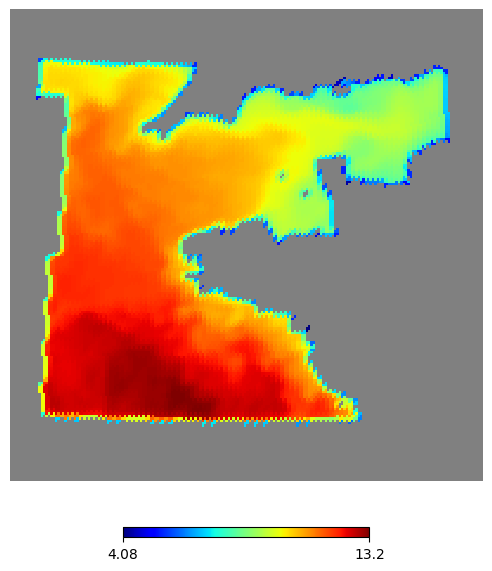

In [6]:
a=scat.smooth(scat.backend.bk_cast(data[None,:]),cell_ids=cell_ids,nside=nside)
plot_result(a.cpu().numpy()[0,:],cell_ids,nside)

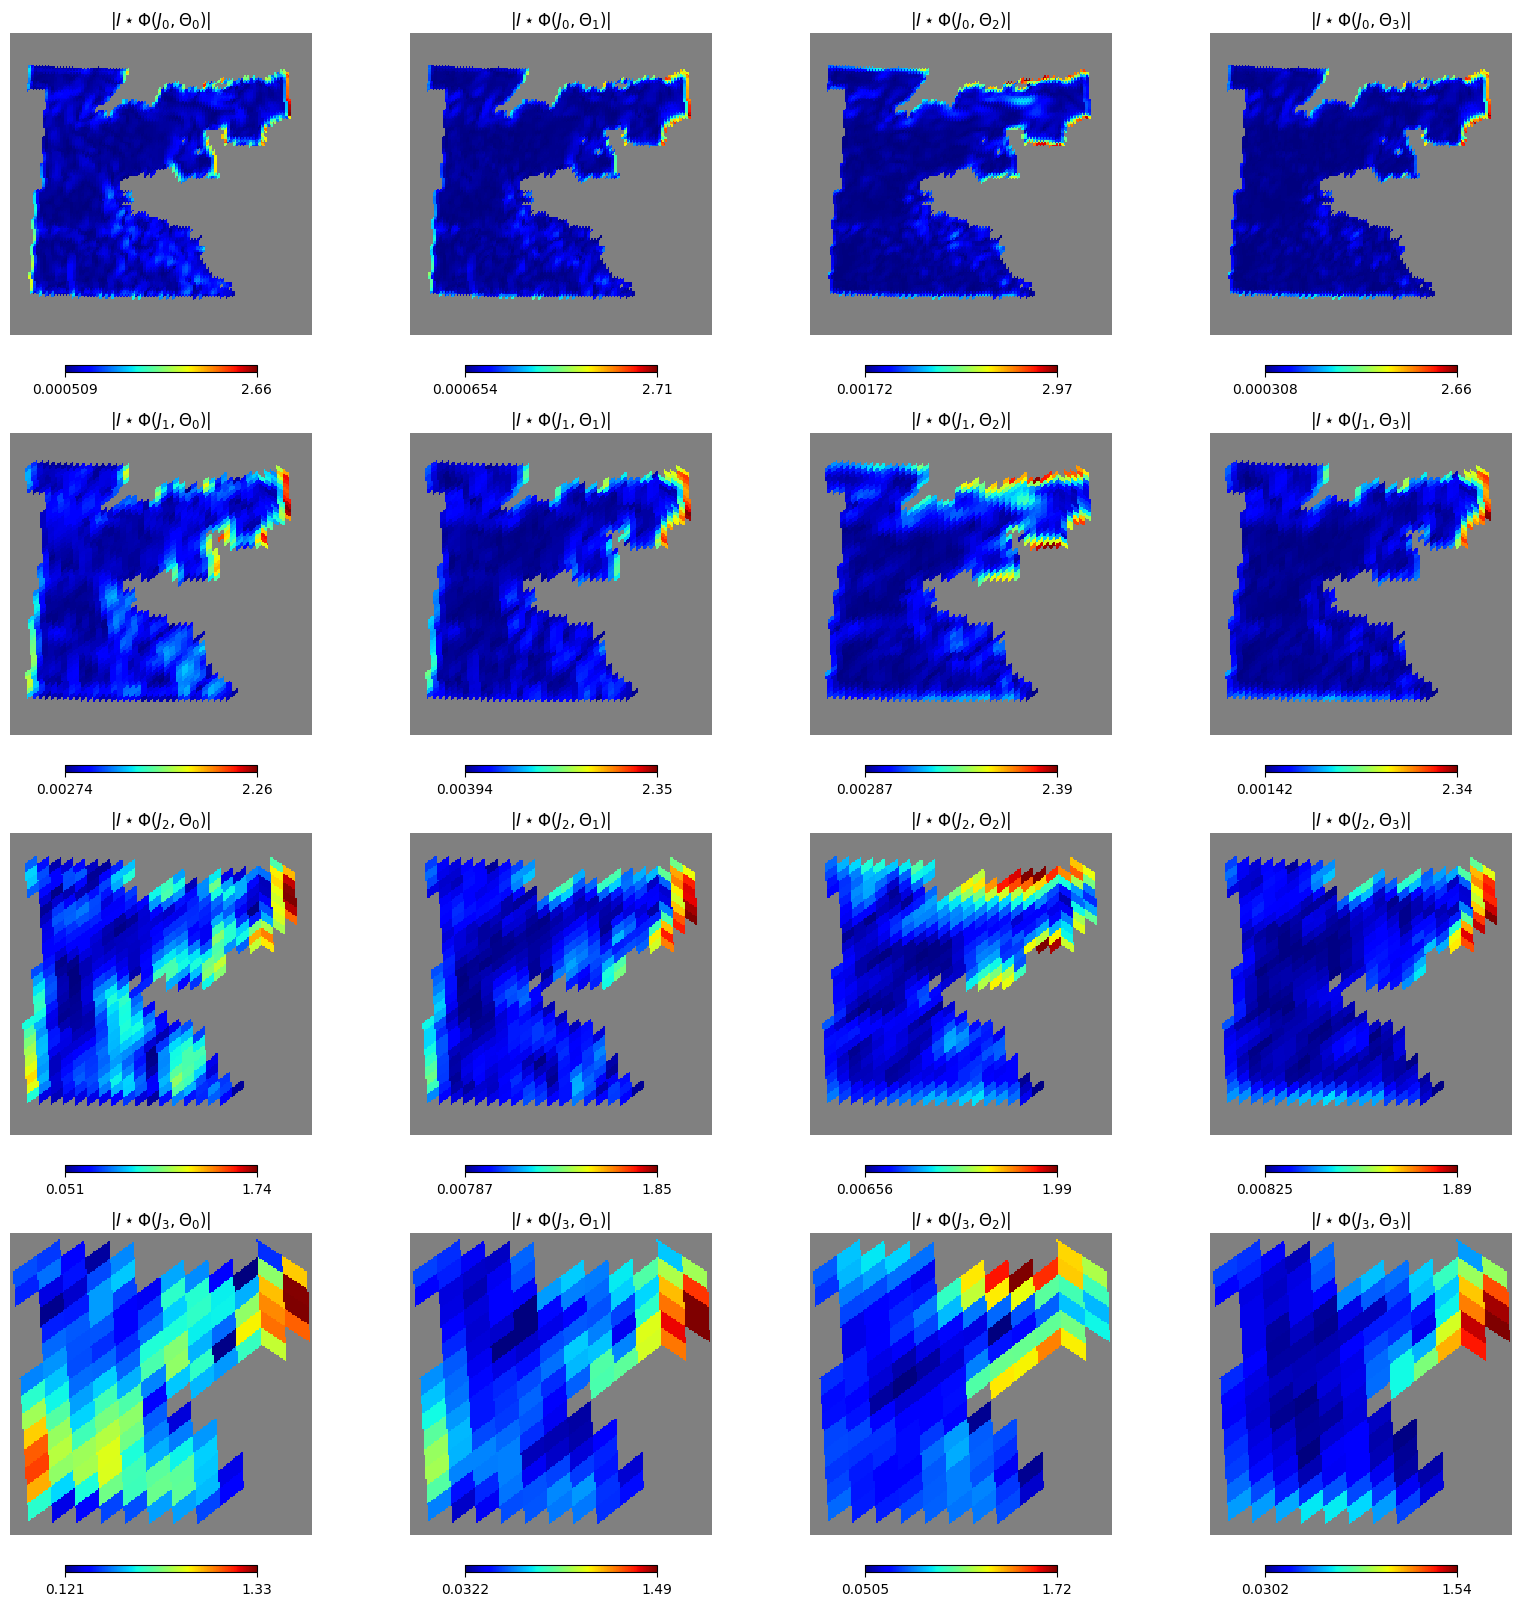

In [7]:
l_data=scat.backend.bk_cast(data[None,:]-np.median(data))

plt.figure(figsize=(16,16))
l_nside=nside
l_cell_ids=cell_ids.copy()
nscale=4
for l in range(nscale):
    wave=scat.convol(l_data,cell_ids=l_cell_ids,nside=l_nside)
    for k in range(4):
        plot_result(abs(wave.cpu().numpy()[0,:,k]),l_cell_ids,l_nside,hold=False,
                    sub=(nscale,4,1+k+4*l),unit='',title=r'$|I\star\Phi(J_%d,\Theta_%d)|$'%(l,k))
    l_data=scat.smooth(l_data,cell_ids=l_cell_ids,nside=l_nside)
    l_data,l_cell_ids=scat.ud_grade_2(l_data,cell_ids=l_cell_ids,nside=l_nside)
    l_nside//=2

In [8]:
a=scat.eval(data-np.median(data),Jmax=5,cell_ids=cell_ids,nside=nside)
b=scat.eval(np.random.randn(data.shape[0])*np.std(data),Jmax=5,cell_ids=cell_ids,nside=nside)

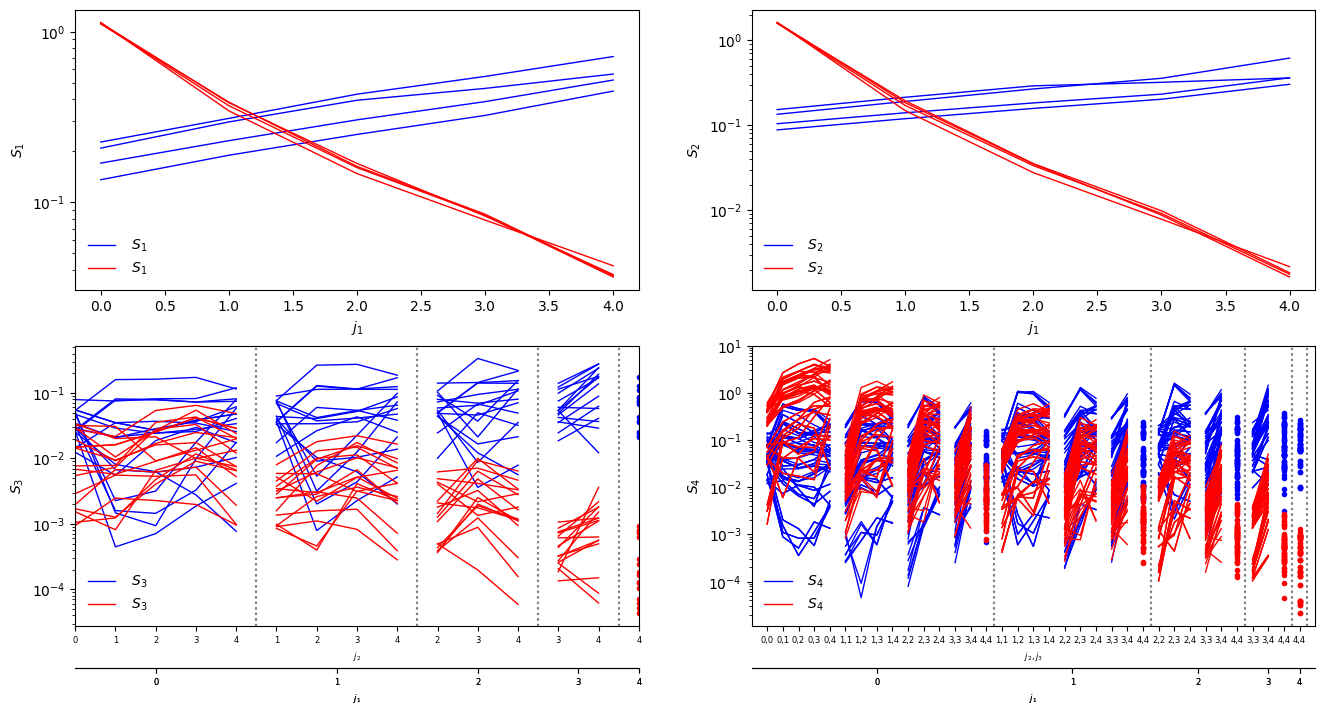

In [9]:
a.plot(color='b')
b.plot(hold=False,color='r')

In [10]:
def The_loss(u,scat_operator,args):
    ref  = args[0]
    sref = args[1]
    cell_ids =args[2]
    nside = args[3]

    # compute scattering covariance of the current synthetised map called u
    learn=scat_operator.eval(u,norm='self',cell_ids=cell_ids,nside=nside,Jmax=5)

    # make the difference withe the reference coordinates
    loss=scat_operator.reduce_distance(learn,ref,sigma=sref)

    return(loss)

In [11]:
ref,sref=scat.eval(data-np.median(data),Jmax=5,cell_ids=cell_ids,nside=nside,calc_var=True)

loss=synthe.Loss(The_loss,scat,ref,sref,cell_ids,nside)

sy = synthe.Synthesis([loss])

In [35]:
imap=np.random.randn(1,data.shape[0])*np.std(data)

omap=scat.to_numpy(sy.run(imap,
            EVAL_FREQUENCY=1,
            NUM_EPOCHS = 3))

Total number of loss  1
Itt      0 L=      1.72 (      1.72 ) 4.253s 
Itt      1 L=     0.455 (     0.455 ) 9.416s 
Itt      2 L=     0.182 (     0.182 ) 4.697s 
Itt      3 L=    0.0985 (    0.0985 ) 4.698s 
Final Loss  0.0984911173582077


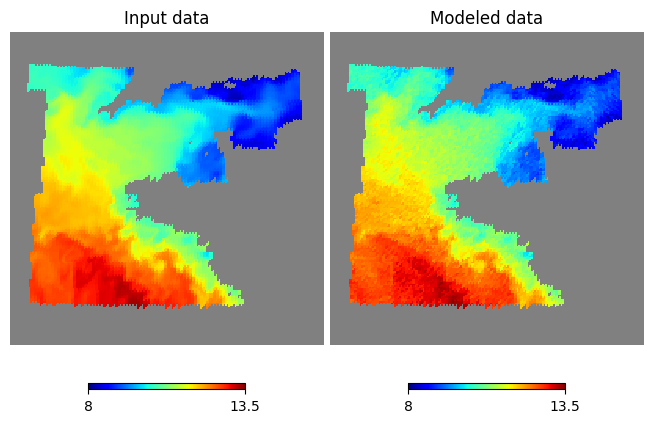

In [36]:
plot_result(data,cell_ids,nside,hold=False,sub=(1,2,1),title='Input data',vmin=8,vmax=13.5)
plot_result(omap+np.median(data),cell_ids,nside,hold=False,sub=(1,2,2),title='Modeled data',vmin=8,vmax=13.5)